In [1]:
# There was a bag in the moadel saving proccess,
# because if the tensorflow version is higher than 2.9,
# then there will be error during saving the model
import tensorflow as tf

tf.__version__

'2.9.0'

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [4]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



In [5]:
!kaggle datasets download -d gpiosenka/cats-in-the-wild-image-classification
from zipfile import ZipFile
file_name = "/content/cats-in-the-wild-image-classification.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

 98% 121M/123M [00:01<00:00, 104MB/s] 
100% 123M/123M [00:01<00:00, 77.9MB/s]
Done


In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL

import os
import cv2


In [7]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import splitfolders

In [9]:
img_gen = ImageDataGenerator(rescale=1/255)

In [10]:
train = img_gen.flow_from_directory(directory='/content/train', target_size=(224,224), seed=42)
test = img_gen.flow_from_directory(directory='/content/test', target_size=(224,224), seed=42)
val = img_gen.flow_from_directory(directory='/content/valid', target_size=(224,224), seed=42)


Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [11]:
train_dataset = keras.utils.image_dataset_from_directory('/content/train',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224, 224))

Found 2339 files belonging to 10 classes.


In [12]:
val_dataset = keras.utils.image_dataset_from_directory('/content/valid',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224, 224))

Found 50 files belonging to 10 classes.


In [13]:
test_dataset = keras.utils.image_dataset_from_directory('/content/test',
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224, 224))

Found 50 files belonging to 10 classes.


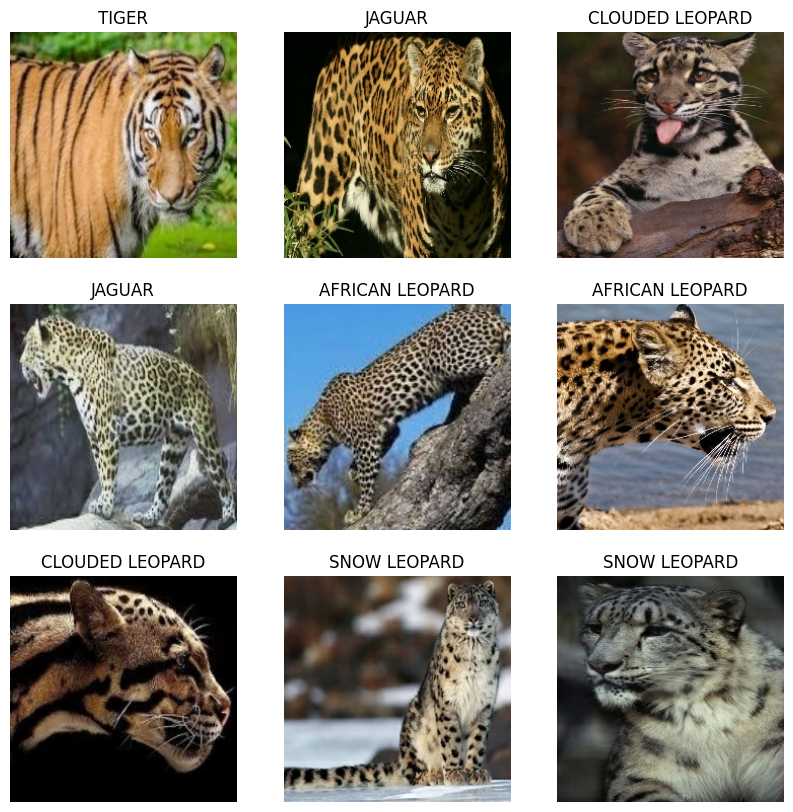

In [14]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

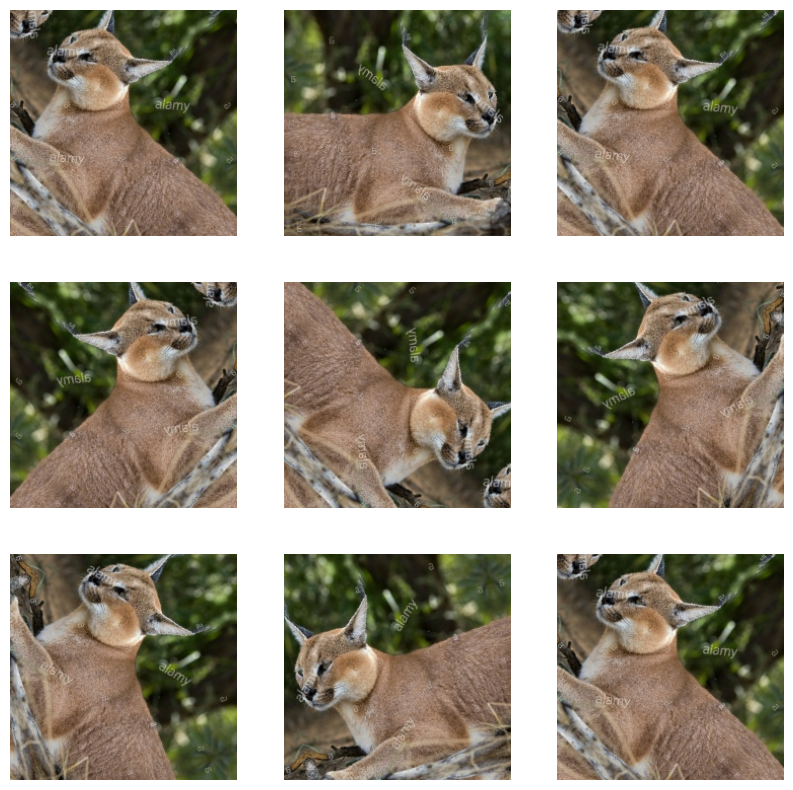

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [18]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [44]:

base_model = tf.keras.applications.EfficientNetB1(input_shape=(224,224,3),
                                                 include_top=False,
                                                 weights='imagenet')

In [45]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [46]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape, label_batch.shape)

(32, 7, 7, 1280) (32,)


In [47]:
base_model.trainable = False

In [48]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [49]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [50]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [51]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [52]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [53]:
print("Shape of label_batch:", label_batch.shape)
print("Shape of prediction_batch:", prediction_batch.shape)


Shape of label_batch: (32,)
Shape of prediction_batch: (32, 10)


In [54]:
# Efficentnetb1
train_metrics = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
74/74 [==============================] - 305s 4s/step - loss: 2.1276 - accuracy: 0.2548 - val_loss: 1.8841 - val_accuracy: 0.4800
Epoch 2/5
74/74 [==============================] - 272s 4s/step - loss: 1.6984 - accuracy: 0.5806 - val_loss: 1.5111 - val_accuracy: 0.7400
Epoch 3/5
74/74 [==============================] - 274s 4s/step - loss: 1.3881 - accuracy: 0.7392 - val_loss: 1.2269 - val_accuracy: 0.8200
Epoch 4/5
74/74 [==============================] - 292s 4s/step - loss: 1.1429 - accuracy: 0.8166 - val_loss: 1.0133 - val_accuracy: 0.9000
Epoch 5/5
74/74 [==============================] - 282s 4s/step - loss: 0.9744 - accuracy: 0.8555 - val_loss: 0.8516 - val_accuracy: 0.9400


In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                           

In [56]:
model.evaluate(test_dataset)

2/2 [==============================] - 5s 2s/step - loss: 0.8632 - accuracy: 0.9200


[0.8632011413574219, 0.9200000166893005]

In [57]:
len(model.trainable_variables)

2

In [58]:
# Efficentnetb1
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_dataset)

2/2 [==============================] - 7s 3s/step - loss: 0.8516 - accuracy: 0.9400


In [59]:
base_model.trainable = True

In [60]:
len(base_model.layers)

340

In [61]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:338]:
  layer.trainable = False


Number of layers in the base model:  340


In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [63]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [64]:
initial_epochs = 5

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=train_metrics.epoch[-1],
                         validation_data=val_dataset)

Epoch 5/10
74/74 [==============================] - 288s 4s/step - loss: 0.8164 - accuracy: 0.8769 - val_loss: 0.6770 - val_accuracy: 0.9600
Epoch 6/10
74/74 [==============================] - 283s 4s/step - loss: 0.6867 - accuracy: 0.9029 - val_loss: 0.5600 - val_accuracy: 0.9600
Epoch 7/10
74/74 [==============================] - 275s 4s/step - loss: 0.5998 - accuracy: 0.9068 - val_loss: 0.4747 - val_accuracy: 0.9600
Epoch 8/10
74/74 [==============================] - 275s 4s/step - loss: 0.5326 - accuracy: 0.9094 - val_loss: 0.4114 - val_accuracy: 0.9600
Epoch 9/10
74/74 [==============================] - 282s 4s/step - loss: 0.4825 - accuracy: 0.9162 - val_loss: 0.3651 - val_accuracy: 0.9800
Epoch 10/10
74/74 [==============================] - 275s 4s/step - loss: 0.4445 - accuracy: 0.9183 - val_loss: 0.3268 - val_accuracy: 0.9600


In [65]:
type(model)

keras.engine.functional.Functional

In [66]:
model

In [1]:
# pip install tensorflow==2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting unin

In [67]:
model.save('animal_model_cat_race.h5')

In [ ]:
# just a drafts, that I did not want to delete
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.evaluate(test_dataset, batch_size=32)

2/2 [==============================] - 7s 1s/step - loss: 0.2919 - accuracy: 0.9600


[0.29190272092819214, 0.9599999785423279]